In [1]:
# download birds data from https://www.kaggle.com/datasets/gpiosenka/100-bird-species?resource=download and save in data folder
!unzip -q -n data/birds.zip -d data/birds

unzip:  cannot find or open data/birds.zip, data/birds.zip.zip or data/birds.zip.ZIP.


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [4]:
import timm
# timm resource: https://towardsdatascience.com/getting-started-with-pytorch-image-models-timm-a-practitioners-guide-4e77b4bf9055
# choose a model form timm using https://www.kaggle.com/code/jhoward/which-image-models-are-best
model = timm.create_model('convnext_tiny.in12k_ft_in1k', pretrained=True)

In [5]:
# view model default config:
model.default_cfg

{'url': '',
 'hf_hub_id': 'timm/convnext_tiny.in12k_ft_in1k',
 'architecture': 'convnext_tiny',
 'tag': 'in12k_ft_in1k',
 'custom_load': False,
 'input_size': (3, 224, 224),
 'test_input_size': (3, 288, 288),
 'fixed_input_size': False,
 'interpolation': 'bicubic',
 'crop_pct': 0.95,
 'test_crop_pct': 1.0,
 'crop_mode': 'center',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'num_classes': 1000,
 'pool_size': (7, 7),
 'first_conv': 'stem.0',
 'classifier': 'head.fc'}

In [6]:
# get ds labels
# find all images in train set
train_image_paths = !find data/birds/train \( -iname '*jpeg' -o -iname '*jpg' -o -iname '*png' \) -type f 
print('First 3 images paths:', train_image_paths[:3] )
labels = list({image_path.split("/")[3] for image_path in train_image_paths})
print('First 3 labels:', labels[:3])
num_labels = len(labels)
print('Number of labels:', num_labels)

First 3 images paths: ['data/birds/train/AMERICAN AVOCET/124.jpg', 'data/birds/train/AMERICAN AVOCET/022.jpg', 'data/birds/train/AMERICAN AVOCET/107.jpg']
First 3 labels: ['BUSH TURKEY', 'MALABAR HORNBILL', 'CRIMSON CHAT']
Number of labels: 525


In [7]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/birds'
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) 
    for x in ['train', 'valid']}
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4) 
    for x in ['train', 'valid']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

Using device: cuda:0


In [8]:
dataset_sizes

{'train': 84635, 'valid': 2625}

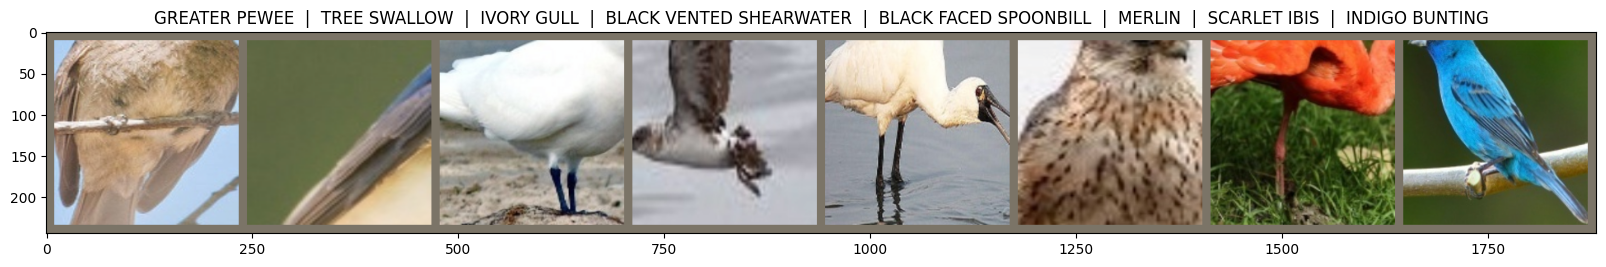

In [9]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
plt.figure(figsize=(20,10))
out = torchvision.utils.make_grid(inputs[:8], nrow=8, padding =10)
imshow(out, title="  |  ".join([class_names[x] for x in classes[:8]]))

In [10]:
# freeze all layers
for param in model.parameters():
    param.requires_grad = False
# replace final layer and freeze other layers

# CHECK MODEL CONFIG FOR NAME OF CLASSIFIER HEAD (head.fc in this case)
num_features = model.head.fc.in_features
print('Num Features:', num_features)
model.head.fc = nn.Linear(num_features, num_labels) # replace the final layer

Num Features: 768


In [11]:
model_comp = torch.compile(model)

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.33E-03


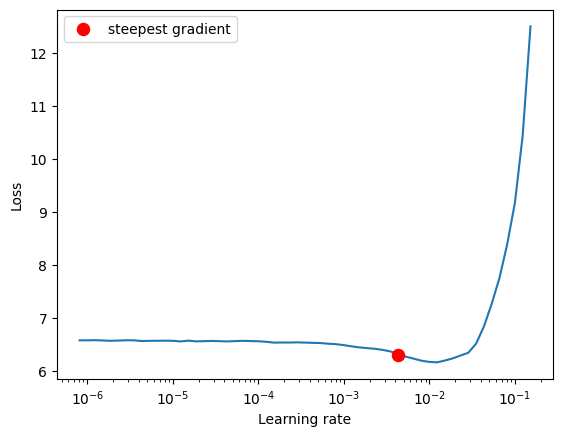

In [12]:
# explore learning rates
from torch_lr_finder import LRFinder

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.head.fc.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(dataloaders['train'], end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [13]:
lr = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_comp.head.fc.parameters(), lr=lr) # only training fc layer
# reduce learning rate by 0.1 every 5 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) 

Using: cuda
Epoch 0/0
----------


train Loss: 5.7682 Acc: 55355/84635 = 0.6540


val Loss: 1.6166 Acc: 2359/2625 = 0.8987
New best accuracy: 0.899

Training complete in 5m 9s
Best val Acc: 0.898667


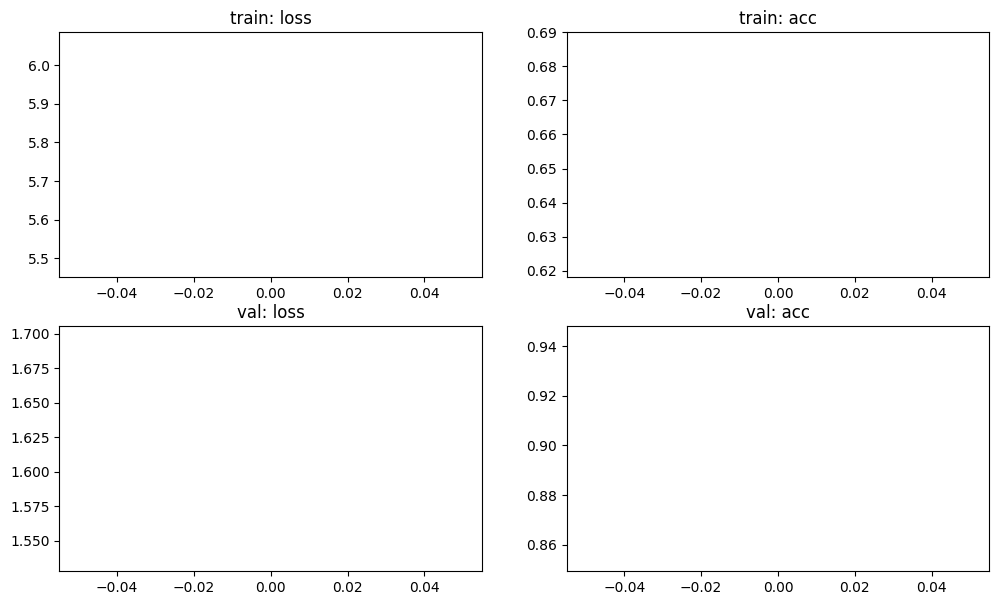

In [14]:
from utils.train import train_model
torch.set_float32_matmul_precision('high')
model, history = train_model(
    model=model_comp,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=lr_scheduler,
    num_epochs=1,
    device='cuda',
    train_loader=dataloaders['train'],
    val_loader=dataloaders['valid'])